## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
include("../src/GeneralizedPhaseModel.jl");
using PyCall

In [2]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 12
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

sys:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


### Model definition

In [3]:
# Parameters and variables
c = 0.7; d = 0.8; eps = 0.08; # FHN parameters

# FHN vector field
dvdt(X, I) = X[1] - X[1]^3/3.0 - X[2] + I + 0.875
dudt(X) = eps * (X[1] + c - d * X[2])
F(X, I) = [dvdt(X, I), dudt(X)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ([-1 1; 1 -1] * X[:, 1])
dt = 5e-4; T = 200; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5();

In [4]:
@time Ts, ω, Xs = FindStablePeriodicSolution(F, 0, D, Nθ, [2, 0.5], dt, alg, 1, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  5.099202 seconds (41.39 M allocations: 2.046 GiB, 9.15% gc time, 79.43% compilation time)
Ts=36.4185 (sec) , ω=0.17252729539051817 (Hz)


In [5]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = ComputeGeneralizedPhaseSensitivityFunction(F, -0.55, 0.55, 0.01, D, Nθ, nothing, dt, alg, 1, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:02:24


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [6]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

In [7]:
function coupled_original_system_fhn(N, D, Nt, dt, XsI, G, coupled_func!, initθ, κ, alg=Tsit5())
    X = zeros(Nt, N, D)
    initX = hcat([[XsI[j](θ, 0) for j in 1:D] for θ in initθ]...)'
    integrator = get_ode_integrator(coupled_func!, initX, dt, (G, κ), alg)
    for tt in 1:Nt
        x = copy(integrator.u)
        X[tt, :, :] = x # memory
        step!(integrator, dt, true)
    end
    return X 
end

coupled_original_system_fhn (generic function with 2 methods)

If `K>0.10`, IΘ cannot be computed because it's outside the range of external forces that can produce a stable periodic orbit.

In [8]:
alg = Tsit5()
NΘ = 100
K = 0.10 
κ = [1.0, 1.5]
initθ = [0, π/2];
g(X) = G(X, K)

g (generic function with 1 method)

In [9]:
QΘ = ComputeQΘ(g, N, D, XsI, κ, ωI, NΘ);

Computing P(θ₁, θ₂)...100%|█████████████████████████████| Time: 0:01:44


In [10]:
IΘ = ComputeIsΘ(g, N, D, XsI, NΘ);

Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00


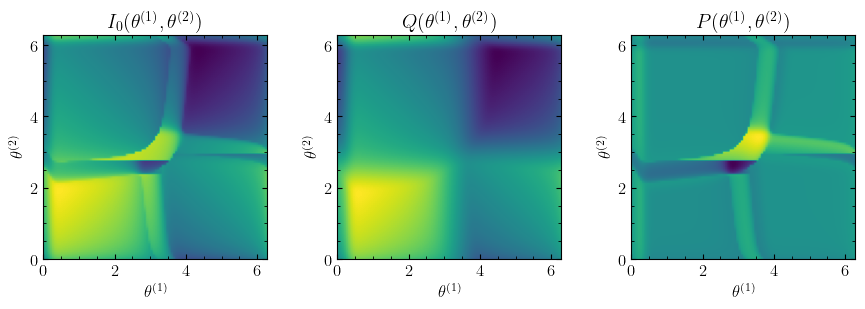

In [11]:
Θrange = range(0, 2π, length=100)
figure(figsize=(9,3))
subplot(1,3,1)
title(L"$I_0(\theta^{(1)}, \theta^{(2)})$")
imshow(IΘ[1](Θrange, Θrange), extent=[0, 2pi, 0, 2pi])
xlabel(L"$\theta^{(1)}$"); ylabel(L"$\theta^{(2)}$");
subplot(1,3,2)
title(L"$Q(\theta^{(1)}, \theta^{(2)})$")
imshow(QΘ[1](Θrange, Θrange), extent=[0, 2pi, 0, 2pi])
xlabel(L"$\theta^{(1)}$"); ylabel(L"$\theta^{(2)}$");
subplot(1,3,3)
title(L"$P(\theta^{(1)}, \theta^{(2)})$")
imshow(IΘ[1](Θrange, Θrange)-QΘ[1](Θrange, Θrange), extent=[0, 2pi, 0, 2pi])
xlabel(L"$\theta^{(1)}$"); ylabel(L"$\theta^{(2)}$");
tight_layout()

### Run simulation

In [12]:
Xos = coupled_original_system_fhn(N, D, Nt, dt, XsI, g, coupled_func!, initθ, κ, alg)
Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, Nt, dt, XsI, g, ωI, ζθI, initθ, κ, alg);
Xgpm, Θgpm = coupled_generalized_phase_model_PQ(N, D, Nt, dt, XsI, QΘ, ωI, ζθI, ξθI, initθ, κ, g, alg);

### Results

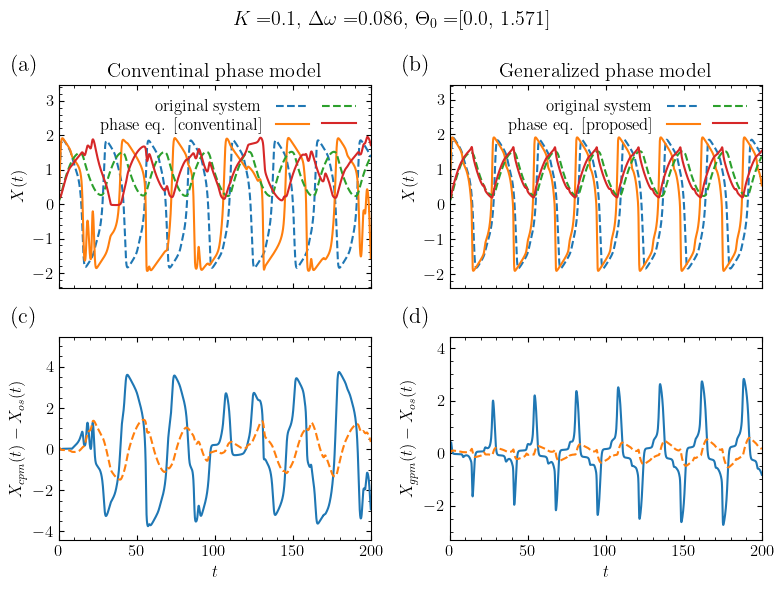

In [13]:
figure(figsize=(8, 6))
suptitle(L"$K=$"*string(K)*L", $\Delta \omega=$"*string(round((κ[2]-κ[1])*ω, digits=3))*L", $\Theta_0=$"*string(round.(initθ, digits=3)))
ax1 = subplot(2,2,1)
title("Conventinal phase model")
plot(trange, Xos[:, 1, 1], "--", label="original system")
plot(trange, Xcpm[:, 1, 1], label="phase eq. [conventinal]")
plot(trange, Xos[:, 1, 2], "--", label=" ")
plot(trange, Xcpm[:, 1, 2], label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.3); ylabel(L"$X(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax1.text(-0.15, 1.15, "(a)", fontsize=16, transform=ax1.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax2 = subplot(2,2,2)
title("Generalized phase model")
plot(trange, Xos[:, 1, 1], "--", label="original system")
plot(trange, Xgpm[:, 1, 1], label="phase eq. [proposed]")
plot(trange, Xos[:, 1, 2], "--", label=" ")
plot(trange, Xgpm[:, 1, 2], label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.3);  ylabel(L"$X(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax2.text(-0.15, 1.15, "(b)", fontsize=16, transform=ax2.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax3 = subplot(2,2,3)
plot(trange, Xcpm[:, 1, 1]-Xos[:, 1, 1])
plot(trange, Xcpm[:, 1, 2]-Xos[:, 1, 2], "--")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.3); ylabel(L"$X_{cpm}(t)-X_{os}(t)$"); xlabel(L"$t$");
ax3.text(-0.15, 1.15, "(c)", fontsize=16, transform=ax3.transAxes, fontweight="bold", va="top")

ax4 = subplot(2,2,4)
plot(trange, Xgpm[:, 1, 1]-Xos[:, 1, 1])
plot(trange, Xgpm[:, 1, 2]-Xos[:, 1, 2], "--")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.3);  ylabel(L"$X_{gpm}(t)-X_{os}(t)$"); xlabel(L"$t$");
ax4.text(-0.15, 1.15, "(d)", fontsize=16, transform=ax4.transAxes, fontweight="bold", va="top")

tight_layout()

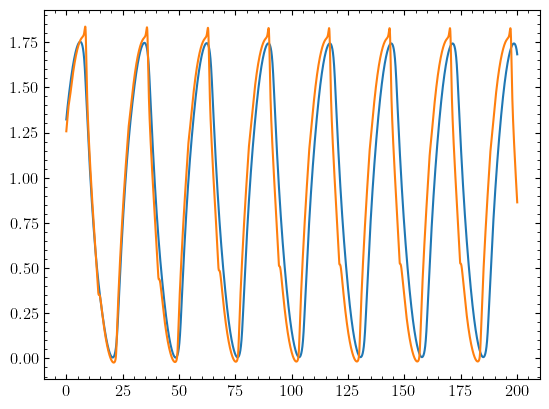

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000001300730A0>

In [15]:
plot(trange, Xos[:, 2, 2], label=" ")
plot(trange, Xgpm[:, 2, 2], label=" ")